Author: Jonah So

email: jonahso@ucsb.edu

In [2]:
# Import Required Libraries
import cudaq
import numpy as np
import time
import sys
from cudaq import spin
from cudaq import State
import matplotlib.pyplot as plt
from typing import List
from plot_config import *

In [3]:
@cudaq.kernel
def get_initial_state(n_spins: int):
    """Create initial state |1010...>"""
    qubits = cudaq.qvector(n_spins)
    for i in range(0, n_spins, 2):
        x(qubits[i])

### First-Order Product Formula (PF1)

We can decompose the Hamiltonian as:

$
H = \sum_{l=1}^L H_l = \sum_{l=1}^L c_l P_l
$

where:
- $c_l \in \mathbb{R}$ are the coefficients,
- $P_l$ are Pauli words (tensor products of Pauli matrices).

The ideal time evolution operator is:
$
U(t) = e^{-i H t}
$

The first-order Trotter approximation replaces this by sequentially applying each term:
$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t}
$


### Second-order Product Formulas (PF2) 
The second-order approximation is a combination of evolutions in both increasing and decreasing orders of indice. 
More formally, we can write this as: 

$
U(\delta t) \;\approx\; \prod_{l} e^{-i H_l \, \delta t / 2} \prod_{l} e^{-i H_l \, \delta t / 2}  
$

- Each term $H_l$ is applied twice with a half-step $\delta t / 2$.
- The first product applies the exponentials in increasing order of $l$.
- The second product applies them in decreasing order of $l$.

The following code creates the model that was used in the paper: **QIMF** 

The hamiltonian is defined as the following: 

$
H \;=\; 
h_x \sum_{j=1}^N X_j \;+\;
h_y \sum_{j=1}^N Y_j \;+\;
J \sum_{j=1}^{N-1} X_j X_{j+1}
$

- $X_j, Y_j, Z_j$: Pauli operators on qubit \(j\).


In [4]:
def create_hamiltonian_qimf(n_spins: int, J: float, h_x: float, h_y: float):
    A = 0 
    B = 0
    for j in range(n_spins - 1):
        A += J * spin.x(j) * spin.x(j + 1) 
        
    for j in range(n_spins):
        A += h_x * spin.x(j)
        B += h_y * spin.y(j)

    return A, B, A+B

### Trotter Approximation (PF1) 
The time-evolution operator 
$
e^{-i H \delta t}
$
 can be split into two non-commuting parts:

$
A = h_x \sum_j X_j \;+\; J \sum_j X_j X_{j+1}, 
\qquad
B = h_y \sum_j Y_j
$

so that the first-order Trotter step is:

$
\mathcal{U}_1(\delta t) \;\approx\; e^{-i A \delta t} \, e^{-i B \delta t}
$ 

In [5]:
@cudaq.kernel 
def trotter_step_pf1 (state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    qubits = cudaq.qvector(state)
    
    for i in range(len(c_a)):
        exp_pauli(-c_a[i].real * dt, qubits, words_a[i])
        
    for i in range(len(c_b)):
        exp_pauli(-c_b[i].real * dt, qubits, words_b[i])
        

### Trotter Approximation (PF2) 
Similar to PF1, we can define 

$
U(\delta t) \;\approx\; 
e^{-i A \, \tfrac{\delta t}{2}} \,
e^{-i B \, \delta t} \,
e^{-i A \, \tfrac{\delta t}{2}}
$

We apply all A-terms again with half timestep $\delta t / 2$, in reverse order for symmetry.

In [6]:
@cudaq.kernel
def trotter_step_pf2(state: cudaq.State, dt: float, c_a: List[complex], c_b: List[complex], words_a: List[cudaq.pauli_word], words_b: List[cudaq.pauli_word]):
    
    qubits = cudaq.qvector(state)
    
    for i in range(len(words_a)):
        exp_pauli(c_a[i].real * (0.5*dt), qubits, words_a[i])
        
    for i in range(len(words_b)):
        exp_pauli(c_b[i].real * dt, qubits, words_b[i])
        
    for i in range(len(words_a)-1, -1, -1):
        exp_pauli(c_a[i].real * (0.5*dt), qubits, words_a[i]) 


Here, we extract coefficients and words from Hamiltonian for decomposition. 

In [7]:
def extractCoefficients(hamiltonian: cudaq.SpinOperator):
    result = []
    for term in hamiltonian:
        result.append(term.get_coefficient())
    return result

def extractWords(hamiltonian: cudaq.SpinOperator):
    n_spins = hamiltonian.qubit_count
    result = []
    for term in hamiltonian:
        result.append(term.get_pauli_word(n_spins))
    return result

### Entropy Measure

Given a pure state $|\psi\rangle$ of an $n$-qubit system, the reduced density matrix for a subset of qubits $A$ is

$
\rho_A = \mathrm{Tr}_B \big( |\psi\rangle \langle \psi | \big),
$

where $B$ is the set of qubits traced out.

We can quantify its entanglement with the rest of the system by calculating von Neumann entropy:

$S(\rho) = - \text {Tr} [\rho \log \rho] = - \sum_i \lambda_i \log_2 \lambda_i$

where $\lambda_i$ are the eigenvalues of the reduced density matrix.

In [8]:
import cupy as cp 
def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [9]:
def entropy(rho):
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]  
    return -cp.sum(eigvals * cp.log2(eigvals))

In [10]:
def purity(rho):
    return cp.real(cp.trace(rho @ rho)).item() 

In [11]:
def simulation (n_spins: int, cal: str, sub: int, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0): 
    n = n_spins
    state = initial_state
    out_list = []
    time_list = []

    dt = 0.1
    subsystem = list(range(sub)) 

    h_x = np.full(n_spins, h_x_val) 
    h_y = np.full(n_spins, h_y_val) 
    h_z = np.zeros(n_spins)
    J = 1.0 

    A, B, H = create_powerlaw_hamiltonian(n_spins = n_spina)
    
    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)

    start_time = time.time()
    for step in range(1, r + 1): 
        state = cudaq.get_state(trotter_step_pf1, state, dt, c_a, c_b, words_a, words_b)
        psi = cp.array(state)
        rho_A = partial_trace (psi, subsystem, n_qubits=n_spins)
        
        if cal == 'purity':
            S = purity(rho_A)
        elif cal == 'entropy':
            S = entropy(rho_A)
        else:
            print('invalid input') 
            return 1 
            
        out_list.append(S)
        time_list.append(dt * step)
    
    total_time = time.time() - start_time
    print(f"Simulation for subsystem {len(subsystem)} done in {total_time:.2f} seconds")
    out_np = np.array([x.get() if hasattr(x, 'get') else x for x in out_list])
    
    return out_np, subsystem

In [12]:
from cupyx.scipy.linalg import expm 

def tro_U (A, B, dt):
    Am = cp.asarray(A.to_matrix(), dtype=cp.complex128)
    Bm = cp.asarray(B.to_matrix(), dtype=cp.complex128)
    U_a = expm(-1j * Am * dt)
    U_b = expm(-1j * Bm * dt)
    return U_a @ U_b 

def tro_next_state(U, state):
    # return U_a @ (U_b @ state)
    return U @ state

In [13]:
import cupy as cp
from cupyx.scipy.linalg import expm

def ideal_U (H, dt): 
    Hm = cp.asarray(H.to_matrix(), dtype=cp.complex128)
    return expm(-1j * Hm * dt)  
    
def ideal_next_state(U, state):
    # psi = cp.asarray(state, dtype=cp.complex128)
    return U @ state


In [14]:
def trotter_error(psi_ideal, psi_trot):
    return ((cp.linalg.norm(psi_ideal - psi_trot)))

In [15]:
def trotter_error_dm (dm_ideal, dm_trotter):
    return (cp.linalg.norm(dm_ideal - dm_trotter))

In [16]:
def ideal_simulation (n_spins: int, cal: str, sub: int, initial_state, r=100, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0): 
    n = n_spins
    ideal_state = cp.asarray(initial_state)
    t_state = initial_state
    
    out_list_ideal = []
    out_list_trotter = [] 
    
    time_list = []
    error_list = [] 

    dt = 0.1
    subsystem = list(range(sub)) 

    h_x = np.full(n_spins, h_x_val) 
    h_y = np.full(n_spins, h_y_val) 
    h_z = np.zeros(n_spins)
    J = 1.0 

    A, B, H = create_hamiltonian_qimf(n_spins, J=J_val, h_x=h_x_val, h_y=h_y_val)
    
    start_time = time.time()
    
    c_a = extractCoefficients(A)
    c_b = extractCoefficients(B)
    words_a = extractWords(A)
    words_b = extractWords(B)
    U = ideal_U(H, dt) 
    # U_t = tro_U(A, B, dt)
    prev_error = 0 
    psi_t = cp.asarray(t_state, dtype=cp.complex128)
    print(cp.linalg.norm(psi_t - ideal_state))  
    
    for step in range(1, r + 1): 
        # prev_error = cp.linalg.norm((ideal_state - psi_t)) 
        psi_t = cp.asarray(t_state, dtype=cp.complex128)
        
        ideal_state = ideal_next_state(U, psi_t)
        t_state = cudaq.get_state(trotter_step_pf1, t_state, dt, c_a, c_b, words_a, words_b)
        
        psi_t = cp.asarray(t_state, dtype=cp.complex128)
        tro_error = (cp.linalg.norm(psi_t - ideal_state))
        
        # print(cp.linalg.norm(psi_t - ideal_state) - prev_error)
        # print(psi_t.shape, ideal_state.shape) 
        # rho_t = psi_t @ psi_t.conj().T 

    
        # t2 = ideal_next_state(U_t, ideal_state)
        
        # rho_ideal = ideal_state @ ideal_state.conj().T
        
        # tro_error = trotter_error_dm(rho_ideal, rho_t)

        rho_A_ideal = partial_trace(ideal_state, subsystem, n_qubits=n_spins)
        rho_A_t = partial_trace(psi_t, subsystem, n_qubits=n_spins)
        
        if cal == 'purity':
            S = purity(rho_A_ideal)
            
        elif cal == 'entropy':
            S_ideal = entropy(rho_A_ideal) 
            S_t = entropy(rho_A_t)
            
            # print(cp.linalg.norm(psi_t - t2), cp.linalg.norm(psi_t - ideal_state))
        
        else:
            print('invalid input') 
            return 1 
            
        out_list_ideal.append(S_ideal)
        out_list_trotter.append(S_t) 
        time_list.append(dt * step)
        error_list.append(tro_error) 

    total_time = time.time() - start_time
    print(f"Simulation for subsystem {len(subsystem)} done in {total_time:.2f} seconds")
    out_np_ideal= np.array([x.get() if hasattr(x, 'get') else x for x in out_list_ideal])
    out_np_trotter = np.array([x.get() if hasattr(x, 'get') else x for x in out_list_trotter])
    error_np = np.array([x.get() if hasattr(x, 'get') else x for x in error_list])
    
    return out_np_ideal, out_np_trotter, subsystem, error_np

In [17]:
def plot (n, initial_state, subsystem, t_list, r, typical: bool = True): 
    if (typical):
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
        for i in range(1, subsystem + 1):
            n_12_p, sub_12_p = simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
            axes.plot(t_list, n_12_p, label=f'typical {i}-RDM entropy')
        axes.legend()
        axes.set_xlabel('Time')
        axes.set_ylabel('Entropy') 
    if (typical == False):   
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), sharex=True)
        for i in range(1, subsystem + 1):
            n_12_p, sub_12_p = simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
            axes[0].plot(t_list, n_12_p, label=f'typical {i}-RDM entropy')
        for i in range(1, subsystem + 1):
            n_12_p, sub_12_p = simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.0, h_y_val=0.9045, J_val=1.0)
            axes[1].plot(t_list, n_12_p, label=f'atypical {i}-RDM entropy')
        axes[1].legend()
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Entropy') 

        axes[0].legend()
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Entropy') 


In [18]:
def ideal_plot (n, initial_state, subsystem, t_list, r, typical: bool = True): 
    if (typical):
        fig, axes = plt.subplots(nrows=1, ncols=1)
        ax2 = axes.twinx()
        for i in range(1, subsystem + 1):
            n_12_p, n_trotter, sub_12_p, error = ideal_simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
            ax2.plot(t_list, n_12_p, label=f'typical {i}-RDM entropy')
            ax2.plot(t_list, n_trotter, label=f'typical {i}-RDM entropy trotter')
            axes.plot(t_list, error, label='trotter error', linestyle=":")
            
        ax2.legend()
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Entropy') 
        axes.set_ylabel("trotter error")
        axes.set_yticks([0.05, 0.075, 0.10, 0.125, 0.15])
        axes.legend() 
        
    if (typical == False):   
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), sharex=True)
        for i in range(1, subsystem + 1):
            n_12_p, sub_12_p = ideal_simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.8090, h_y_val=0.9045, J_val=1.0)
            axes[0].plot(t_list, n_12_p, label=f'typical {i}-RDM entropy')
        for i in range(1, subsystem + 1):
            n_12_p, sub_12_p = ideal_simulation (n, 'entropy', i, initial_state, r=r, h_x_val=0.0, h_y_val=0.9045, J_val=1.0)
            axes[1].plot(t_list, n_12_p, label=f'atypical {i}-RDM entropy')
        axes[1].legend()
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Entropy') 

        axes[0].legend()
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Entropy') 


/tmp/ipykernel_2294462/722446967.py:4: DeprecationWarning: use `evaluate_coefficient` instead
  result.append(term.get_coefficient())


0.0
Simulation for subsystem 1 done in 4.06 seconds
0.0
Simulation for subsystem 2 done in 3.15 seconds
0.0
Simulation for subsystem 3 done in 3.28 seconds
0.0
Simulation for subsystem 4 done in 3.25 seconds
0.0
Simulation for subsystem 5 done in 3.58 seconds
0.0
Simulation for subsystem 6 done in 3.23 seconds


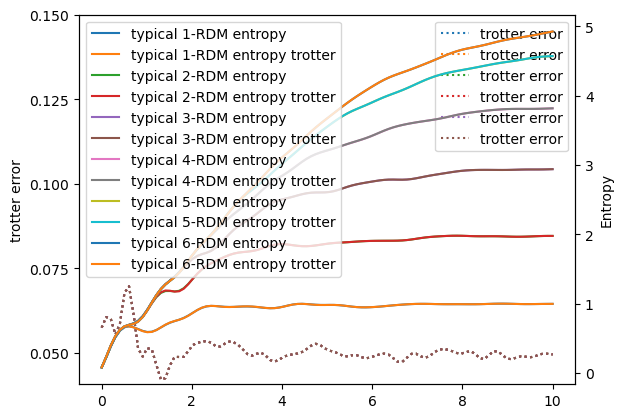

In [19]:
n = 12
r = 100
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 6

t_list = np.linspace(0, 10, 100) 

ideal_plot(n, initial_state, subsystem,t_list, r)

In [21]:
# H_pl = Power_Law(n=5, alpha=4, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)
def create_powerlaw_hamiltonian(n_spins: int, Jx: float = 1.0, Jy: float = 1.0, 
                                Jz: float = 1.0, h_x: float = 1.0, h_y: float = 1.0, h_z: float = 1.0, alpha: float = 4.0):
    A = 0 
    B = 0 
    for i in range(n_spins):
        for j in range(i + 1, n_spins):
            r = j - i
            A += (Jx / (r ** alpha)) * spin.x(i) * spin.x(j)
            A += (Jy / (r ** alpha)) * spin.y(i) * spin.y(j)
            A += (Jz / (r ** alpha)) * spin.z(i) * spin.z(j)

    for i in range(n_spins):
        B += h_x * spin.x(i)
        B += h_y * spin.y(i)
        B += h_z * spin.z(i)

    return A, B, A + B


In [ ]:
n = 20
initial_state = cudaq.get_state(get_initial_state, n)
subsystem = 6
r = 200
t_list = np.linspace(0, 20, 200) 

plot(n, initial_state, subsystem, t_list, r) 